In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'Colombia GeoJson'
geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#geojson

In [4]:
# Data cleaning and adjusting
translator = Translator()

translations = {}
departments = {}

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']

data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [5]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [78]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):
    
def removeElements(A, B): 
    n = len(A) 
    return any(A == B[i:i + n] for i in range(len(B)-n + 1)) 

def numbers(div):
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div):
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasifivación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia) [Beta]

In [79]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=list(departments.values()),
    featureidkey='properties.NOMBRE_DPT',
    geojson=geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0.55,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Colombia: {len(data.index):,} casos confirmados de COVID-19',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Casos confirmados VS Departamento (Estado)

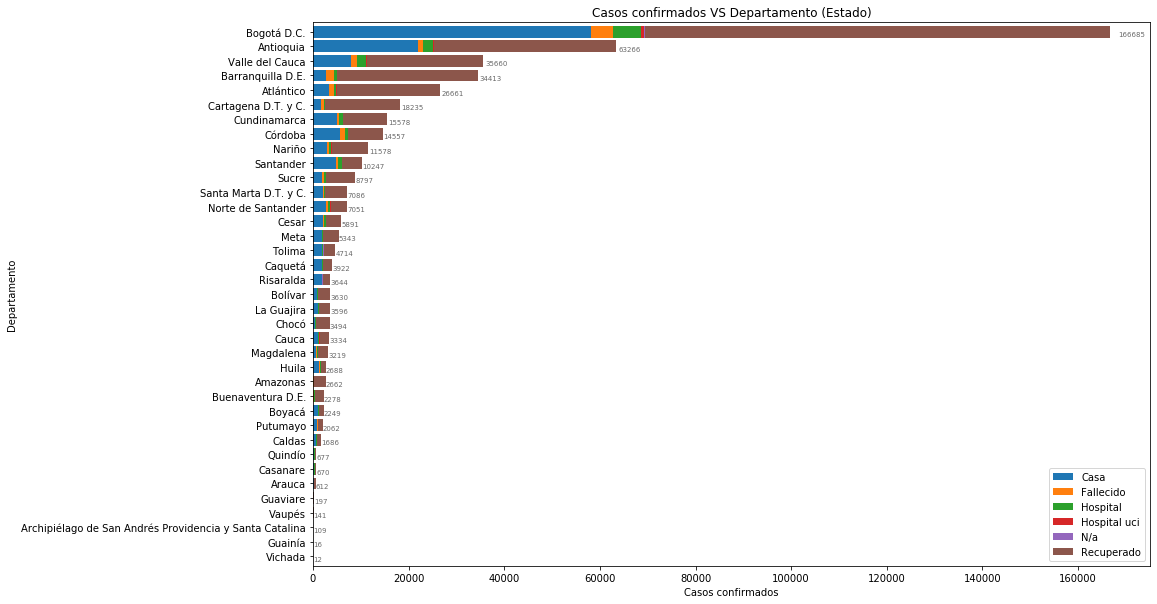

In [80]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [81]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         58226.0     4424.0   
Antioquia                                           21899.0     1201.0   
Valle del Cauca                                      8026.0     1265.0   
Barranquilla D.E.                                    2796.0     1580.0   
Atlántico                                            3256.0     1194.0   
Cartagena D.T. y C.                                  1762.0      492.0   
Cundinamarca                                         5040.0      439.0   
Córdoba                                              5670.0      963.0   
Nariño                                               2856.0      414.0   
Santander                                            4754.0      426.0   
Sucre                                                1887.0      422.0   
Santa Marta D.T. y C.                                2057.0      259.0   
Norte de Santander                                   2749.0      402.0   
Cesar                                                2203.0      130.0   
Meta                                                 1885.0      100.0   
Tolima                                               1889.0      104.0   
Caquetá                                              1864.0      113.0   
Risaralda                                            1792.0       65.0   
Bolívar                                               795.0      152.0   
La Guajira                                            983.0      175.0   
Chocó                                                 329.0      123.0   
Cauca                                                 960.0      120.0   
Magdalena                                             681.0      263.0   
Huila                                                1368.0       69.0   
Amazonas                                              115.0      107.0   
Buenaventura D.E.                                     114.0      155.0   
Boyacá                                               1013.0       54.0   
Putumayo                                              867.0       92.0   
Caldas                                                712.0       24.0   
Quindío                                               293.0       18.0   
Casanare                                              303.0       13.0   
Arauca                                                268.0       11.0   
Guaviare                                               68.0        0.0   
Vaupés                                                 79.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...     58.0        0.0   
Guainía                                                 1.0        2.0   
Vichada                                                 7.0        0.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6039.0         550.0   
Antioquia                                             1968.0         168.0   
Valle del Cauca                                       1717.0         300.0   
Barranquilla D.E.                                      551.0          42.0   
Atlántico                                              416.0          63.0   
Cartagena D.T. y C.                                    209.0          38.0   
Cundinamarca                                           714.0          12.0   
Córdoba                                                665.0          65.0   
Nariño                                                 576.0          39.0   
Santander                                              819.0          39.0   
Sucre                                                  449.0          15.0   
Santa Marta D.T. y C.                                  229.0          14.0   
Norte de Santander   

### - Casos confirmados VS Departamento (Sexo)

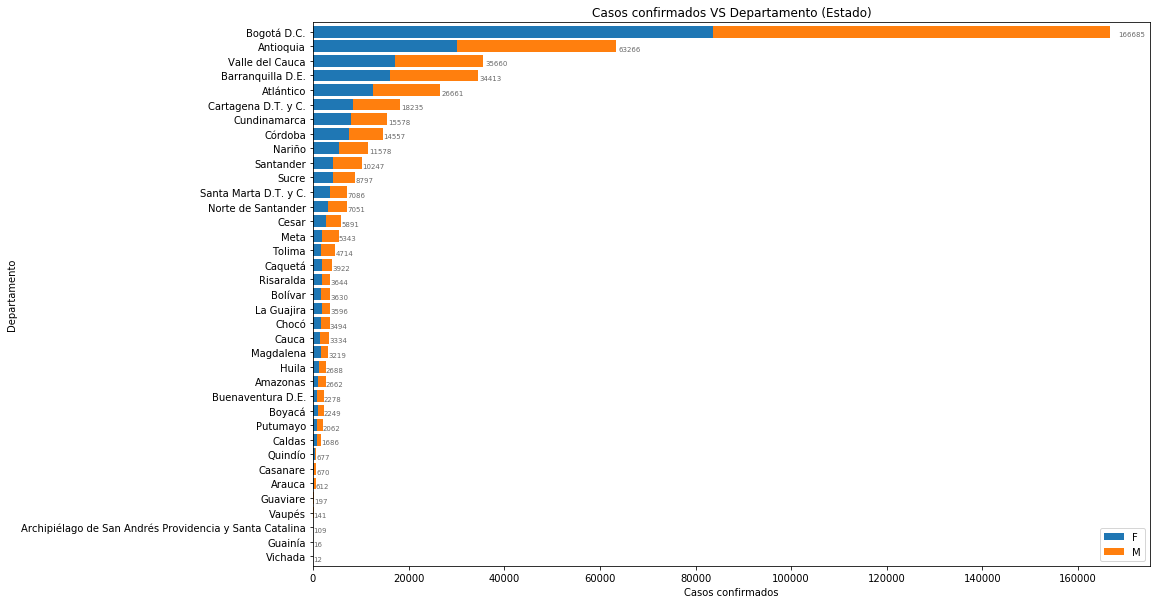

In [82]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [83]:
li.sort_values('Total', ascending=False)

Sexo                                                    F      M   Total
Departamento                                                            
Bogotá D.C.                                         83655  83030  166685
Antioquia                                           30034  33232   63266
Valle del Cauca                                     17126  18534   35660
Barranquilla D.E.                                   16096  18317   34413
Atlántico                                           12637  14024   26661
Cartagena D.T. y C.                                  8336   9899   18235
Cundinamarca                                         7870   7708   15578
Córdoba                                              7448   7109   14557
Nariño                                               5515   6063   11578
Santander                                            4275   5972   10247
Sucre                                                4123   4674    8797
Santa Marta D.T. y C.                                3521   3565    7086
Norte de Santander                                   3117   3934    7051
Cesar                                                2632   3259    5891
Meta                                                 1813   3530    5343
Tolima                                               1756   2958    4714
Caquetá                                              1930   1992    3922
Risaralda                                            1824   1820    3644
Bolívar                                              1634   1996    3630
La Guajira                                           1795   1801    3596
Chocó                                                1631   1863    3494
Cauca                                                1524   1810    3334
Magdalena                                            1614   1605    3219
Huila                                                1347   1341    2688
Amazonas                                             1149   1513    2662
Buenaventura D.E.                                     844   1434    2278
Boyacá                                               1061   1188    2249
Putumayo                                              951   1111    2062
Caldas                                                828    858    1686
Quindío                                               334    343     677
Casanare                                              276    394     670
Arauca                                                176    436     612
Guaviare                                               26    171     197
Vaupés                                                 68     73     141
Archipiélago de San Andrés Providencia y Santa ...     52     57     109
Guainía                                                 7      9      16
Vichada                                                 3      9      12

### - Dataset COVID-19 (Colombia)

In [84]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
476696               2020-08-17           2020-08-16            2020-08-05   
476697               2020-08-17           2020-08-16            2020-08-05   
476698               2020-08-17           2020-08-16            2020-08-05   
476699               2020-08-17           2020-08-16            2020-08-05   
476700               2020-08-17           2020-08-16            2020-08-05   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
476696             2020-08-02 00:00:00                   NaT   
476697             2020-08-02 00:00:00                   NaT   
476698             2020-08-02 00:00:00                   NaT   
476699             2020-08-02 00:00:00                   NaT   
476700             2020-08-02 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
476696                    NaT             Montería          Córdoba      Leve   
476697                    NaT             Montería          Córdoba      Leve   
476698                    NaT             Montería          Córdoba      Leve   
476699                    NaT             Montería          Córdoba      Leve   
476700                    NaT             Montería          Córdoba      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
476696            Casa  ...                20 - 30    F               NaN   
476697            Casa  ...                30 - 40    M               NaN   
476698            Casa  ...                40 - 50    M               NaN   
476699            Casa  ...                40 - 50    F               NaN   
476700            Casa  ...                40 - 50    F               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Mapa de influencia COVID-19 (Colombia)

In [85]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0.55,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Colombia: {len(data.index):,} casos confirmados de COVID-19',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

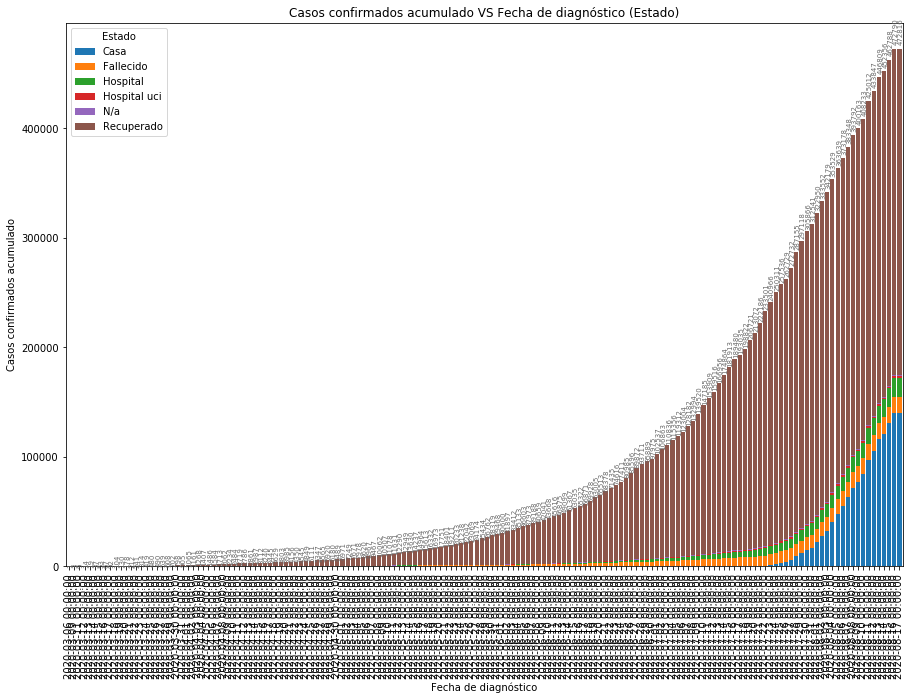

In [86]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [87]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)

Estado                    Casa  Fallecido  Hospital  Hospital uci    N/a  \
Fecha de diagnóstico                                                       
2020-06-19                 6.0     2820.0     888.0         230.0  208.0   
2020-06-20                 6.0     2949.0     973.0         240.0  213.0   
2020-06-21                 6.0     3097.0    1048.0         253.0  226.0   
2020-06-22                 6.0     3190.0    1115.0         261.0  236.0   
2020-06-23                 6.0     3332.0    1212.0         272.0  250.0   
2020-06-24                 6.0     3472.0    1291.0         285.0  258.0   
2020-06-25                 7.0     3632.0    1423.0         304.0  271.0   
2020-06-26                 7.0     3815.0    1545.0         321.0  286.0   
2020-06-27                 8.0     3990.0    1714.0         333.0  297.0   
2020-06-28                 8.0     4152.0    1840.0         342.0  305.0   
2020-06-29                10.0     4259.0    1905.0         352.0  310.0   
2020-06-30                10.0     4318.0    1969.0         358.0  315.0   
2020-07-01                10.0     4529.0    2131.0         379.0  327.0   
2020-07-02                15.0     4733.0    2274.0         406.0  339.0   
2020-07-03                15.0     4929.0    2409.0         422.0  348.0   
2020-07-04                15.0     5120.0    2605.0         446.0  366.0   
2020-07-05                15.0     5264.0    2714.0         464.0  380.0   
2020-07-06                16.0     5394.0    2806.0         477.0  392.0   
2020-07-07                16.0     5602.0    3031.0         507.0  410.0   
2020-07-08                16.0     5839.0    3200.0         535.0  419.0   
2020-07-09                16.0     6130.0    3470.0         576.0  428.0   
2020-07-10                18.0     6346.0    3688.0         602.0  444.0   
2020-07-11                18.0     6601.0    3912.0         622.0  470.0   
2020-07-12                18.0     6809.0    4084.0         651.0  483.0   
2020-07-13                18.0     7070.0    4369.0         693.0  504.0   
2020-07-14                18.0     7350.0    4624.0         719.0  526.0   
2020-07-15                22.0     7631.0    4876.0         750.0  535.0   
2020-07-16                23.0     7904.0    5169.0         780.0  554.0   
2020-07-17                23.0     8067.0    5297.0         793.0  562.0   
2020-07-18                24.0     8296.0    5498.0         824.0  583.0   
2020-07-19                24.0     8563.0    5803.0         854.0  599.0   
2020-07-20                24.0     8822.0    6149.0         892.0  608.0   
2020-07-21                25.0     9152.0    6477.0         943.0  619.0   
2020-07-22                49.0     9570.0    6934.0         998.0  642.0   
2020-07-23               948.0     9915.0    7327.0        1037.0  669.0   
2020-07-24              1856.0    10190.0    7669.0        1073.0  688.0   
2020-07-25              3242.0    10471.0    8020.0        1113.0  699.0   
2020-07-26              3931.0    10691.0    8233.0        1142.0  706.0   
2020-07-27              5821.0    10974.0    8553.0        1188.0  725.0   
2020-07-28              8990.0    11470.0    9147.0        1251.0  755.0   
2020-07-29             11785.0    11723.0    9514.0        1297.0  775.0   
2020-07-30             14935.0    11975.0    9842.0        1345.0  787.0   
2020-07-31             16822.0    12176.0   10110.0        1370.0  802.0   
2020-08-01             21840.0    12470.0   10591.0        1400.0  820.0   
2020-08-02             27956.0    12779.0   11078.0        1422.0  834.0   
2020-08-03             32198.0    13045.0   11521.0        1448.0  847.0   
2020-08-04             40381.0    13275.0   11914.0        1477.0  859.0   
2020-08-05             47729.0    13482.0   12337.0        1493.0  871.0   
2020-08-06             55158.0    13689.0   12693.0        1523.0  886.0   
2020-08-07             63176.0    13892.0   13071.0        1546.0  898.0   
2020-08-08             71963.0    14105.0   1341

### - Casos confirmados VS Fecha de diagnóstico (Estado)

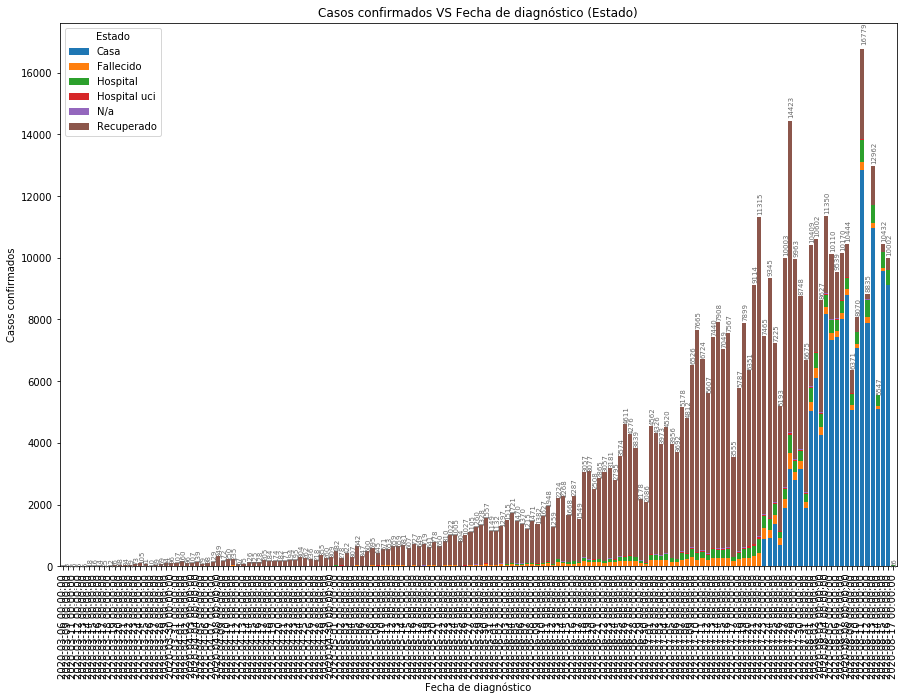

In [88]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [89]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)

Estado                   Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                     
2020-06-19                0.0      133.0      69.0          13.0  14.0   
2020-06-20                0.0      129.0      85.0          10.0   5.0   
2020-06-21                0.0      148.0      75.0          13.0  13.0   
2020-06-22                0.0       93.0      67.0           8.0  10.0   
2020-06-23                0.0      142.0      97.0          11.0  14.0   
2020-06-24                0.0      140.0      79.0          13.0   8.0   
2020-06-25                1.0      160.0     132.0          19.0  13.0   
2020-06-26                0.0      183.0     122.0          17.0  15.0   
2020-06-27                1.0      175.0     169.0          12.0  11.0   
2020-06-28                0.0      162.0     126.0           9.0   8.0   
2020-06-29                2.0      107.0      65.0          10.0   5.0   
2020-06-30                0.0       59.0      64.0           6.0   5.0   
2020-07-01                0.0      211.0     162.0          21.0  12.0   
2020-07-02                5.0      204.0     143.0          27.0  12.0   
2020-07-03                0.0      196.0     135.0          16.0   9.0   
2020-07-04                0.0      191.0     196.0          24.0  18.0   
2020-07-05                0.0      144.0     109.0          18.0  14.0   
2020-07-06                1.0      130.0      92.0          13.0  12.0   
2020-07-07                0.0      208.0     225.0          30.0  18.0   
2020-07-08                0.0      237.0     169.0          28.0   9.0   
2020-07-09                0.0      291.0     270.0          41.0   9.0   
2020-07-10                2.0      216.0     218.0          26.0  16.0   
2020-07-11                0.0      255.0     224.0          20.0  26.0   
2020-07-12                0.0      208.0     172.0          29.0  13.0   
2020-07-13                0.0      261.0     285.0          42.0  21.0   
2020-07-14                0.0      280.0     255.0          26.0  22.0   
2020-07-15                4.0      281.0     252.0          31.0   9.0   
2020-07-16                1.0      273.0     293.0          30.0  19.0   
2020-07-17                0.0      163.0     128.0          13.0   8.0   
2020-07-18                1.0      229.0     201.0          31.0  21.0   
2020-07-19                0.0      267.0     305.0          30.0  16.0   
2020-07-20                0.0      259.0     346.0          38.0   9.0   
2020-07-21                1.0      330.0     328.0          51.0  11.0   
2020-07-22               24.0      418.0     457.0          55.0  23.0   
2020-07-23              899.0      345.0     393.0          39.0  27.0   
2020-07-24              908.0      275.0     342.0          36.0  19.0   
2020-07-25             1386.0      281.0     351.0          40.0  11.0   
2020-07-26              689.0      220.0     213.0          29.0   7.0   
2020-07-27             1890.0      283.0     320.0          46.0  19.0   
2020-07-28             3169.0      496.0     594.0          63.0  30.0   
2020-07-29             2795.0      253.0     367.0          46.0  20.0   
2020-07-30             3150.0      252.0     328.0          48.0  12.0   
2020-07-31             1887.0      201.0     268.0          25.0  15.0   
2020-08-01             5018.0      294.0     481.0          30.0  18.0   
2020-08-02             6116.0      309.0     487.0          22.0  14.0   
2020-08-03             4242.0      266.0     443.0          26.0  13.0   
2020-08-04             8183.0      230.0     393.0          29.0  12.0   
2020-08-05             7348.0      207.0     423.0          16.0  12.0   
2020-08-06             7429.0      207.0     356.0          30.0  15.0   
2020-08-07             8018.0      203.0     378.0          23.0  12.0   
2020-08-08             8787.0      213.0     342.0          20.0   9.0   
2020-08-09             5081.0      137.0     379.0           4.0   4.0   
2020

### - Casos confirmados VS Clasificación de edad (Estado)

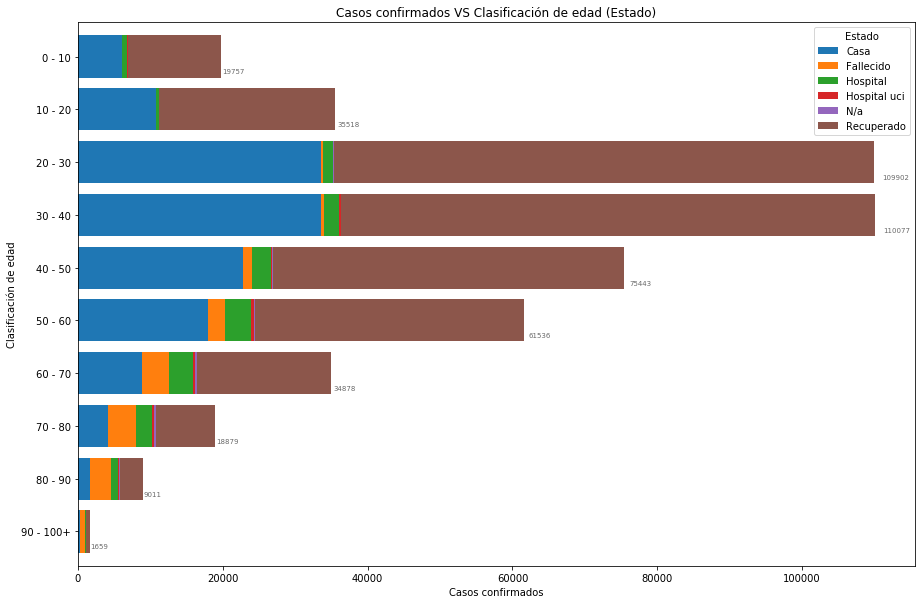

In [90]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [91]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  6058         28       730            57   26   
10 - 20                10774         24       375            25   18   
20 - 30                33569        203      1408            69   43   
30 - 40                33523        508      2085           151   37   
40 - 50                22859       1158      2581           240   76   
50 - 60                17996       2324      3582           413  118   
60 - 70                 8795       3727      3313           373  203   
70 - 80                 4105       3903      2234           241  226   
80 - 90                 1657       2851      1053            64  191   
90 - 100+                289        646       153             6   47   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      12858  
10 - 20                     24302  
20 - 30                     74610  
30 - 40                     73773  
40 - 50                     48529  
50 - 60                     37103  
60 - 70                     18467  
70 - 80                      8170  
80 - 90                      3195  
90 - 100+                     518

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

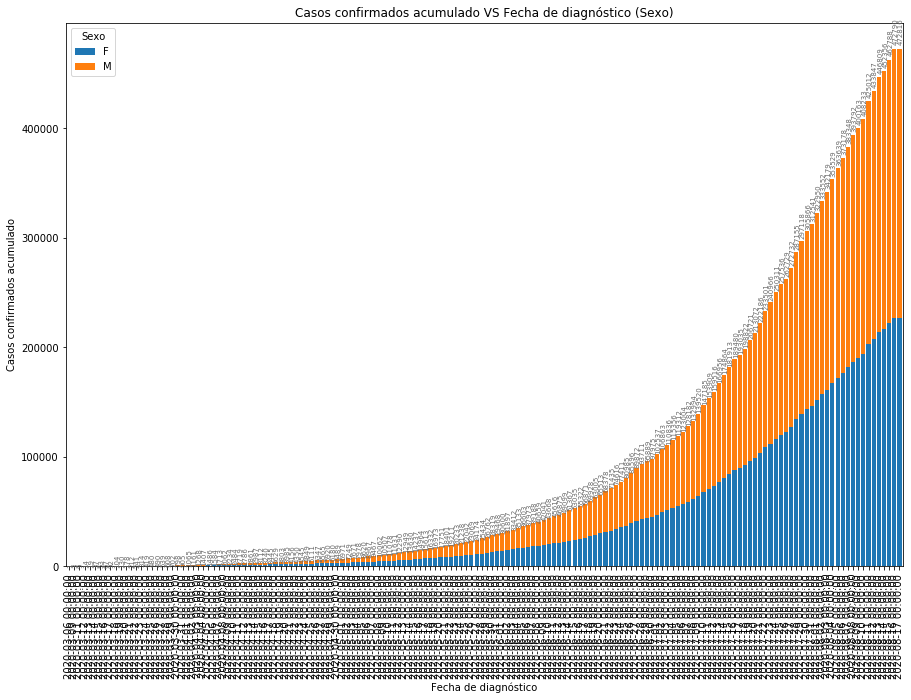

In [92]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [93]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)

Sexo                         F         M
Fecha de diagnóstico                    
2020-06-19             28824.0   34181.0
2020-06-20             29995.0   35518.0
2020-06-21             31244.0   37134.0
2020-06-22             32626.0   38809.0
2020-06-23             34197.0   40419.0
2020-06-24             35541.0   41870.0
2020-06-25             37111.0   43874.0
2020-06-26             39305.0   46291.0
2020-06-27             41301.0   48571.0
2020-06-28             43138.0   50573.0
2020-06-29             44132.0   51757.0
2020-06-30             45104.0   52871.0
2020-07-01             47176.0   55361.0
2020-07-02             49197.0   57666.0
2020-07-03             51053.0   59783.0
2020-07-04             53076.0   62280.0
2020-07-05             54909.0   64403.0
2020-07-06             56658.0   66346.0
2020-07-07             59061.0   69121.0
2020-07-08             61369.0   71625.0
2020-07-09             64330.0   75190.0
2020-07-10             67830.0   79355.0
2020-07-11             71019.0   82890.0
2020-07-12             73687.0   85829.0
2020-07-13             77254.0   89702.0
2020-07-14             80856.0   94008.0
2020-07-15             84191.0   97722.0
2020-07-16             87907.0  101573.0
2020-07-17             89656.0  103379.0
2020-07-18             92430.0  106392.0
2020-07-19             96214.0  110507.0
2020-07-20             99180.0  113892.0
2020-07-21            103444.0  118742.0
2020-07-22            108545.0  124956.0
2020-07-23            112071.0  128895.0
2020-07-24            116387.0  133924.0
2020-07-25            120042.0  137494.0
2020-07-26            122421.0  140308.0
2020-07-27            127208.0  145524.0
2020-07-28            134233.0  152922.0
2020-07-29            139169.0  157949.0
2020-07-30            143418.0  162448.0
2020-07-31            146779.0  165762.0
2020-08-01            151813.0  171137.0
2020-08-02            157233.0  176319.0
2020-08-03            161408.0  180771.0
2020-08-04            167095.0  186434.0
2020-08-05            172183.0  191456.0
2020-08-06            176910.0  196268.0
2020-08-07            181883.0  201465.0
2020-08-08            186956.0  206836.0
2020-08-09            190242.0  209921.0
2020-08-10            194300.0  213933.0
2020-08-11            202990.0  222022.0
2020-08-12            207371.0  226476.0
2020-08-13            213869.0  232940.0
2020-08-14            216669.0  235687.0
2020-08-15            222012.0  240776.0
2020-08-16            227198.0  245592.0
2020-08-17            227210.0  245606.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

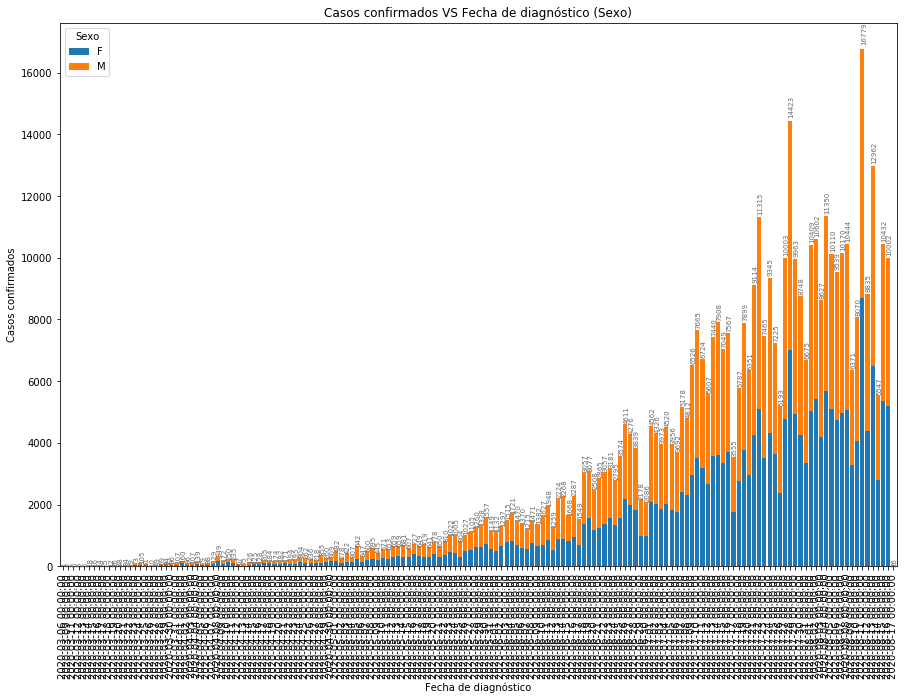

In [94]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [95]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)

Sexo                       F       M
Fecha de diagnóstico                
2020-06-19            1566.0  1511.0
2020-06-20            1171.0  1337.0
2020-06-21            1249.0  1616.0
2020-06-22            1382.0  1675.0
2020-06-23            1571.0  1610.0
2020-06-24            1344.0  1451.0
2020-06-25            1570.0  2004.0
2020-06-26            2194.0  2417.0
2020-06-27            1996.0  2280.0
2020-06-28            1837.0  2002.0
2020-06-29             994.0  1184.0
2020-06-30             972.0  1114.0
2020-07-01            2072.0  2490.0
2020-07-02            2021.0  2305.0
2020-07-03            1856.0  2117.0
2020-07-04            2023.0  2497.0
2020-07-05            1833.0  2123.0
2020-07-06            1749.0  1943.0
2020-07-07            2403.0  2775.0
2020-07-08            2308.0  2504.0
2020-07-09            2961.0  3565.0
2020-07-10            3500.0  4165.0
2020-07-11            3189.0  3535.0
2020-07-12            2668.0  2939.0
2020-07-13            3567.0  3873.0
2020-07-14            3602.0  4306.0
2020-07-15            3335.0  3714.0
2020-07-16            3716.0  3851.0
2020-07-17            1749.0  1806.0
2020-07-18            2774.0  3013.0
2020-07-19            3784.0  4115.0
2020-07-20            2966.0  3385.0
2020-07-21            4264.0  4850.0
2020-07-22            5101.0  6214.0
2020-07-23            3526.0  3939.0
2020-07-24            4316.0  5029.0
2020-07-25            3655.0  3570.0
2020-07-26            2379.0  2814.0
2020-07-27            4787.0  5216.0
2020-07-28            7025.0  7398.0
2020-07-29            4936.0  5027.0
2020-07-30            4249.0  4499.0
2020-07-31            3361.0  3314.0
2020-08-01            5034.0  5375.0
2020-08-02            5420.0  5182.0
2020-08-03            4175.0  4452.0
2020-08-04            5687.0  5663.0
2020-08-05            5088.0  5022.0
2020-08-06            4727.0  4812.0
2020-08-07            4973.0  5197.0
2020-08-08            5073.0  5371.0
2020-08-09            3286.0  3085.0
2020-08-10            4058.0  4012.0
2020-08-11            8690.0  8089.0
2020-08-12            4381.0  4454.0
2020-08-13            6498.0  6464.0
2020-08-14            2800.0  2747.0
2020-08-15            5343.0  5089.0
2020-08-16            5186.0  4816.0
2020-08-17              12.0    14.0

### - Casos confirmados VS Clasificación de edad (Sexo)

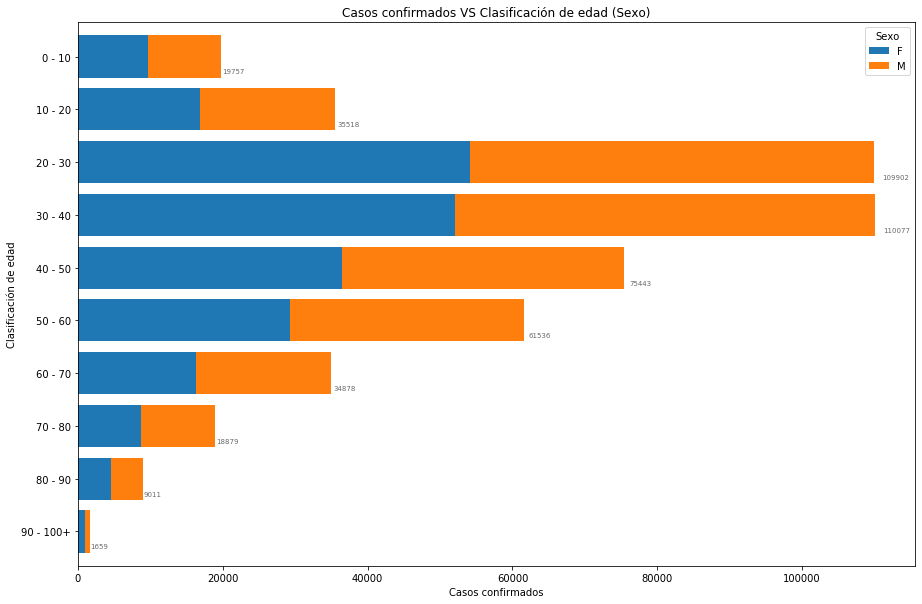

In [96]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [97]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                  9654  10103
10 - 20                16867  18651
20 - 30                54166  55736
30 - 40                52025  58052
40 - 50                36415  39028
50 - 60                29341  32195
60 - 70                16328  18550
70 - 80                 8723  10156
80 - 90                 4559   4452
90 - 100+                950    709

### - Casos confirmados VS Estado (Sexo)

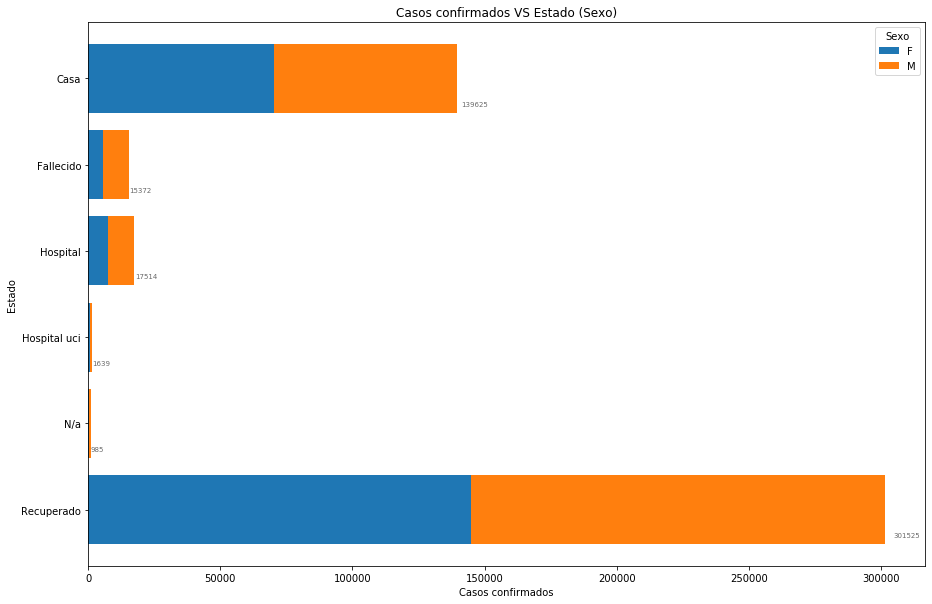

In [98]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [99]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           70348   69277
Fallecido       5516    9856
Hospital        7516    9998
Hospital uci     571    1068
N/a              421     564
Recuperado    144656  156869

### - Casos confirmados VS Tipo de contagio (Sexo)

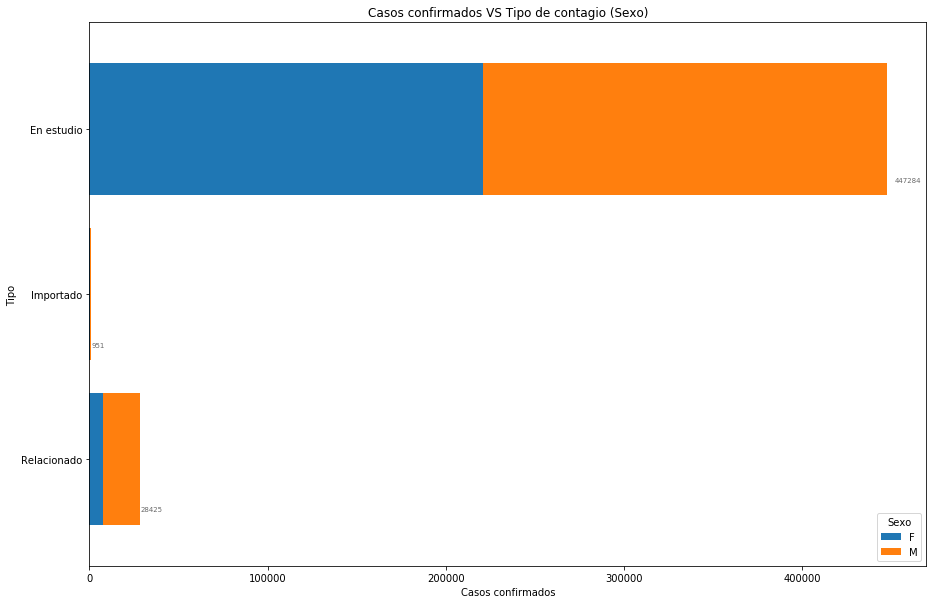

In [100]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [101]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   220794  226490
Importado       446     505
Relacionado    7788   20637

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

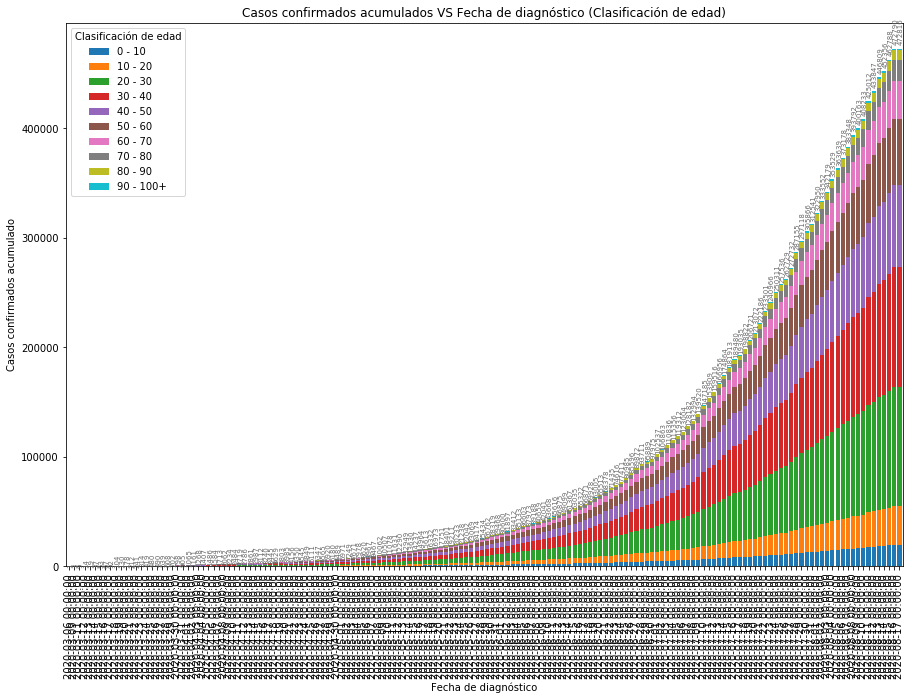

In [102]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [103]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-06-19               3018     5679    14351    13753     9547     7832   
2020-06-20               3133     5827    14947    14346     9934     8164   
2020-06-21               3241     6073    15653    14974    10354     8495   
2020-06-22               3387     6300    16430    15679    10797     8883   
2020-06-23               3539     6553    17160    16385    11289     9290   
2020-06-24               3664     6759    17737    17019    11747     9683   
2020-06-25               3817     7030    18532    17828    12289    10149   
2020-06-26               4035     7362    19581    18946    12984    10712   
2020-06-27               4224     7683    20570    19910    13648    11274   
2020-06-28               4364     7908    21436    20883    14281    11760   
2020-06-29               4462     8081    21975    21386    14627    12011   
2020-06-30               4557     8253    22489    21884    14945    12259   
2020-07-01               4760     8564    23573    22906    15654    12851   
2020-07-02               4926     8883    24571    23878    16343    13422   
2020-07-03               5106     9160    25521    24777    16961    13925   
2020-07-04               5261     9473    26655    25914    17620    14446   
2020-07-05               5413     9746    27549    26820    18232    14995   
2020-07-06               5592    10031    28358    27701    18806    15478   
2020-07-07               5792    10328    29584    28963    19694    16121   
2020-07-08               5981    10654    30676    30105    20464    16745   
2020-07-09               6201    11081    32229    31672    21504    17557   
2020-07-10               6483    11630    34079    33555    22664    18544   
2020-07-11               6732    12075    35697    35171    23744    19400   
2020-07-12               6972    12500    37006    36441    24658    20141   
2020-07-13               7227    12989    38786    38155    25871    21128   
2020-07-14               7523    13571    40659    40033    27147    22103   
2020-07-15               7815    14102    42256    41637    28275    23033   
2020-07-16               8157    14606    43952    43432    29514    24046   
2020-07-17               8280    14824    44751    44291    30059    24497   
2020-07-18               8500    15165    46044    45700    31013    25248   
2020-07-19               8813    15824    47873    47551    32322    26228   
2020-07-20               9090    16281    49223    49007    33387    27055   
2020-07-21               9449    16904    51373    51173    34858    28199   
2020-07-22               9852    17738    54071    53743    36628    29731   
2020-07-23              10127    18248    55733    55472    37817    30710   
2020-07-24              10447    18962    57918    57740    39276    31923   
2020-07-25              10729    19443    59546    59432    40433    32900   
2020-07-26              10939    19766    60730    60652    41237    33577   
2020-07-27              11320    20476    63086    63004    42882    34763   
2020-07-28              11939    21596    66378    66261    45176    36671   
2020-07-29              12308    22317    68755    68680    46822    37877   
2020-07-30              12644    23015    70893    70763    48103    39010   
2020-07-31              12915    23460    72392    72352    49243    39823   
2020-08-01              13318    24303    74912    74831    50841    41137   
2020-08-02              13756    25017    77307    77206    52632    42625   
2020-08-03              14073    25614    79264    79211    53948    43815   
2020-08-04              14552    26414    81879    81852    55808    45373   
2020-08-05              14972    27122    84203    84179    57441    46705   
2020-08-06              15414    27852    86329    86355    58962    47947   
2020-08-07            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

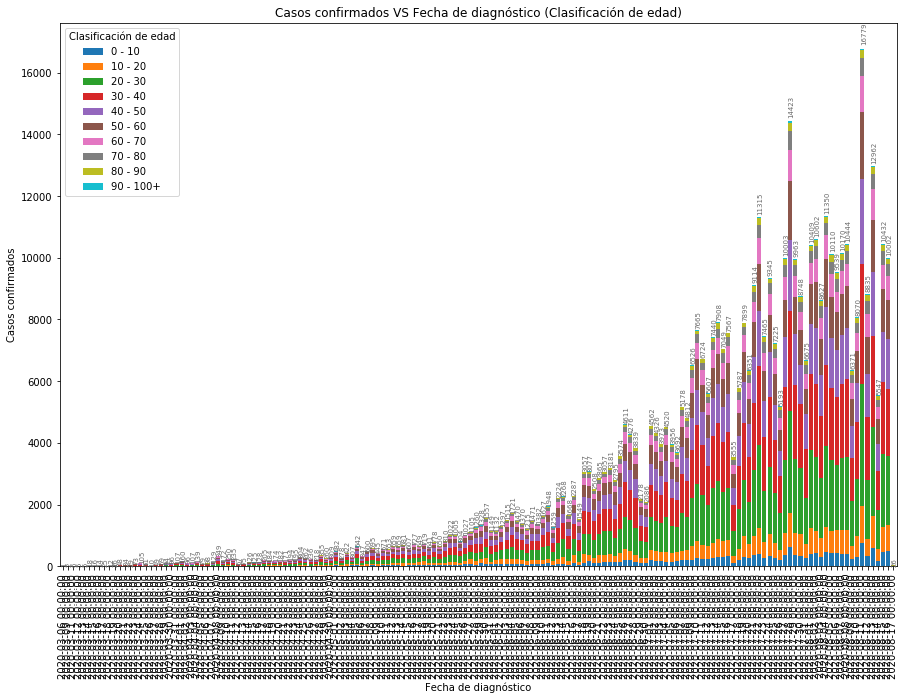

In [104]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [105]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-06-19                159      213      675      698      474      394   
2020-06-20                115      148      596      593      387      332   
2020-06-21                108      246      706      628      420      331   
2020-06-22                146      227      777      705      443      388   
2020-06-23                152      253      730      706      492      407   
2020-06-24                125      206      577      634      458      393   
2020-06-25                153      271      795      809      542      466   
2020-06-26                218      332     1049     1118      695      563   
2020-06-27                189      321      989      964      664      562   
2020-06-28                140      225      866      973      633      486   
2020-06-29                 98      173      539      503      346      251   
2020-06-30                 95      172      514      498      318      248   
2020-07-01                203      311     1084     1022      709      592   
2020-07-02                166      319      998      972      689      571   
2020-07-03                180      277      950      899      618      503   
2020-07-04                155      313     1134     1137      659      521   
2020-07-05                152      273      894      906      612      549   
2020-07-06                179      285      809      881      574      483   
2020-07-07                200      297     1226     1262      888      643   
2020-07-08                189      326     1092     1142      770      624   
2020-07-09                220      427     1553     1567     1040      812   
2020-07-10                282      549     1850     1883     1160      987   
2020-07-11                249      445     1618     1616     1080      856   
2020-07-12                240      425     1309     1270      914      741   
2020-07-13                255      489     1780     1714     1213      987   
2020-07-14                296      582     1873     1878     1276      975   
2020-07-15                292      531     1597     1604     1128      930   
2020-07-16                342      504     1696     1795     1239     1013   
2020-07-17                123      218      799      859      545      451   
2020-07-18                220      341     1293     1409      954      751   
2020-07-19                313      659     1829     1851     1309      980   
2020-07-20                277      457     1350     1456     1065      827   
2020-07-21                359      623     2150     2166     1471     1144   
2020-07-22                403      834     2698     2570     1770     1532   
2020-07-23                275      510     1662     1729     1189      979   
2020-07-24                320      714     2185     2268     1459     1213   
2020-07-25                282      481     1628     1692     1157      977   
2020-07-26                210      323     1184     1220      804      677   
2020-07-27                381      710     2356     2352     1645     1186   
2020-07-28                619     1120     3292     3257     2294     1908   
2020-07-29                369      721     2377     2419     1646     1206   
2020-07-30                336      698     2138     2083     1281     1133   
2020-07-31                271      445     1499     1589     1140      813   
2020-08-01                403      843     2520     2479     1598     1314   
2020-08-02                438      714     2395     2375     1791     1488   
2020-08-03                317      597     1957     2005     1316     1190   
2020-08-04                479      800     2615     2641     1860     1558   
2020-08-05                420      708     2324     2327     1633     1332   
2020-08-06                442      730     2126     2176     1521     1242   
2020-08-07            

### - Casos confirmados VS Estado (Clasificación de edad)

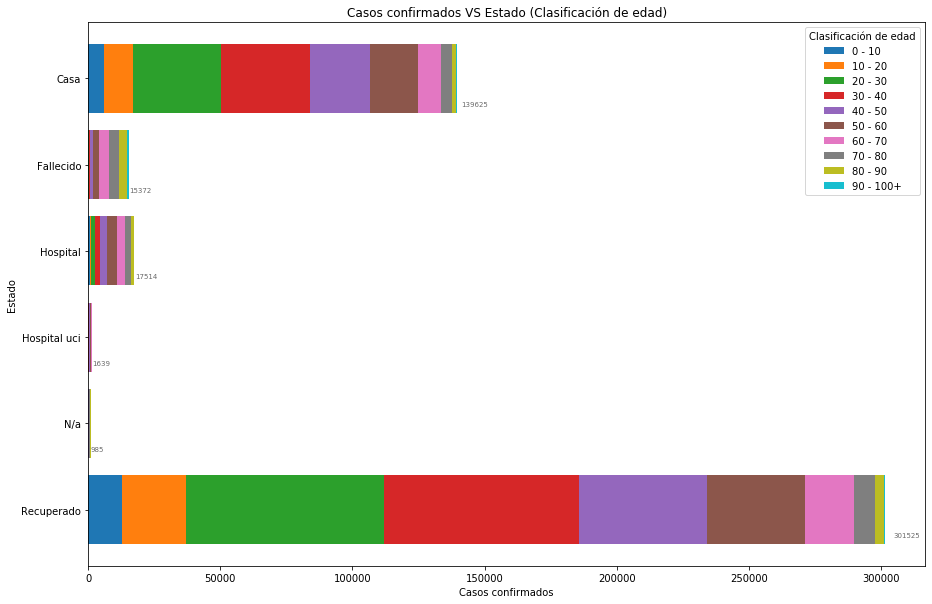

In [106]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [107]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     6058    10774    33569    33523    22859    17996   
Fallecido                  28       24      203      508     1158     2324   
Hospital                  730      375     1408     2085     2581     3582   
Hospital uci               57       25       69      151      240      413   
N/a                        26       18       43       37       76      118   
Recuperado              12858    24302    74610    73773    48529    37103   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      8795     4105     1657        289  
Fallecido                 3727     3903     2851        646  
Hospital                  3313     2234     1053        153  
Hospital uci               373      241       64          6  
N/a                        203      226      191         47  
Recuperado               18467     8170     3195        518

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

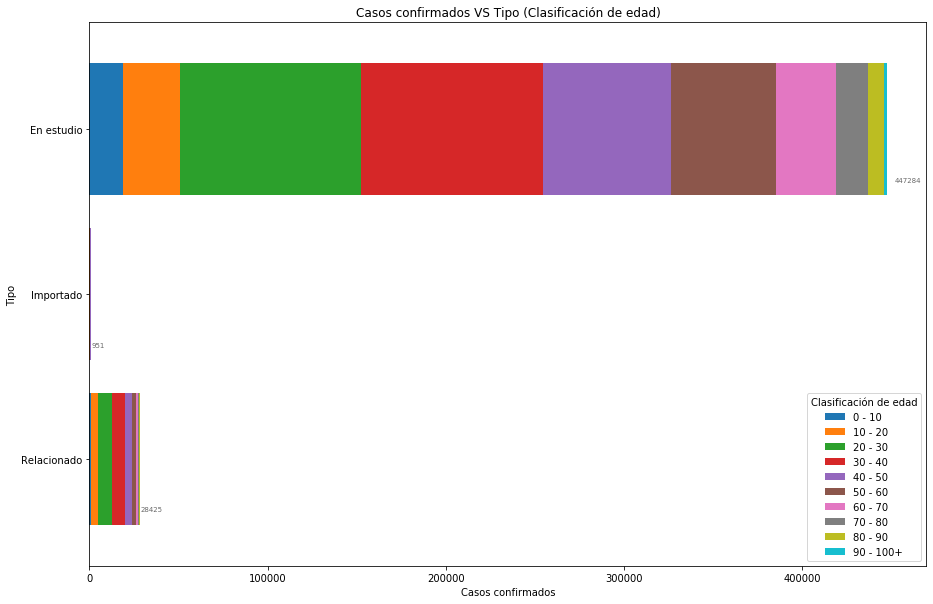

In [108]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [109]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              18780    31836   101548   102506    71682    58936   
Importado                   5       37      240      221      166      143   
Relacionado               972     3645     8114     7350     3595     2457   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               33495    18278     8651       1572  
Importado                   94       35        9          1  
Relacionado               1289      566      351         86

## #StayHome 🏠 #QuédateEnCasa - #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>